## Validating if a digital campaign had a significative change in the daily online conversions of a website

In [0]:
import pandas as pd
import pylab as plt
import numpy as np

In [0]:
import pymc3 as pm
import theano.tensor as tt

In [18]:
df = pd.read_csv("daily_conversions_3m.csv")
df.head()

,day_id,date,conversions
0,1,1/1/2020,528
1,2,1/2/2020,192
2,3,1/3/2020,504
3,4,1/4/2020,408
4,5,1/5/2020,175


#### Exploration

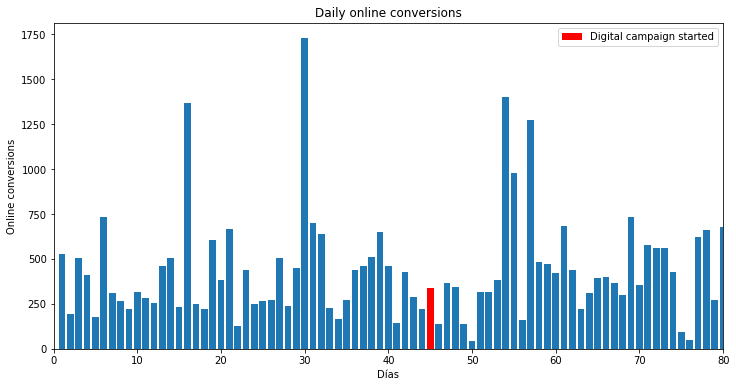

In [48]:
plt.figure(figsize = (12, 6))
plt.bar(df["day_id"].values, df["conversions"].values)
plt.bar(45, 336, color = "r", label = "Digital campaign started")
plt.xlabel("Días")
plt.ylabel("Online conversions")
plt.title("Daily online conversions")
plt.xlim(0, 80)
plt.legend()
plt.savefig('observations.png')

In [20]:
print("Overall mean: " + str(df["conversions"].mean()))
print("Overall std: " + str(df["conversions"].std()))

Overall mean: 437.73333333333335
Overall std: 292.80855424355724


In [21]:
change = 45 # Date in which digital campaign started. 
print("Daily mean conversions before campaign: %f" % np.mean(df[df.day_id < change].conversions)) # Promedio de mensajes diarios antes del día 40.
print("Daily mean conversions after campaign: %f" % np.mean(df[df.day_id >= change].conversions)) # Promedio de mensajes diarios después del día 40.

Daily mean conversions before campaign: 426.022727
Daily mean conversions after campaign: 448.934783


#### Bayesian model



$$
\mu = 
\begin{cases}
\mu_1  & \text{if } t \lt \tau \cr
\mu_2 & \text{if } t \ge \tau
\end{cases}
$$

In [0]:
# Set constants
count_data = df["conversions"].values
n_count_data = len(count_data)

In [0]:
with pm.Model() as model: 
  # Setting prior distributions to our unknown quantities
  # What is a good distribution for the two λs? The exponential is good, as it assigns probabilities to positive real numbers. 
  # The exponential distribution has a parameter too, call it α.
  alpha = 1.0/count_data.mean() # A good idea for α as to reflect our belief is to set the value so that the mean of λ, given α, is equal to our observed mean. 
  mu_1 = pm.Exponential("mu_1", alpha) # Poisson distribution
  mu_2 = pm.Exponential("mu_2", alpha) # Poisson distribution

  # We have a suspicion that there are two λ values, one for the earlier behaviour and one for the later behaviour. We don't know when the behaviour switches though, but call the switchpoint τ.
  # We have no expert opinion of when τ might have occurred. So we will suppose τ is from a discrete uniform distribution over the entire timespan (0 to 90 days).
  tau = pm.DiscreteUniform("tau", lower = 0, upper = n_count_data - 1) 

In [0]:
with model:
  idx = np.arange(n_count_data) # Index where change occurs.
  mu_ = pm.math.switch(tau > idx, mu_1, mu_2) # We use the switch function here to change from λ1 to λ2 at the appropriate time.

In [0]:
with model:
  # Include observations, which are Poisson.
  observation = pm.Poisson("obs", mu_, observed = count_data) 

In [39]:
with model:
  # Compute mu_1, mu_2 y tau.
  step = pm.Metropolis()
  trace = pm.sample(10000, tune = 5000, step = step)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>Metropolis: [mu_2]
>Metropolis: [mu_1]
100%|██████████| 15000/15000 [00:05<00:00, 2912.75it/s]
The number of effective samples is smaller than 25% for some parameters.


#### Results

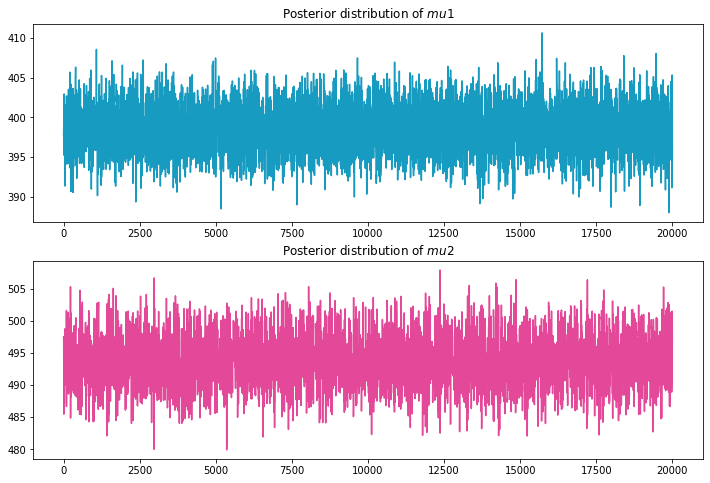

In [47]:
plt.figure(figsize=(12, 8))

ax = plt.subplot(211)
plt.plot(trace['mu_1'], color='#179bc1ff') 
plt.title("Posterior distribution of $mu 1$")

ax = plt.subplot(212)
plt.plot(trace['mu_2'], color='#e34998ff') 
plt.title("Posterior distribution of $mu 2$")

plt.savefig('traces.png')

In [0]:
mu_1_samples = trace['mu_1'] 
mu_2_samples = trace['mu_2'] 
tau_samples = trace['tau']

In [44]:
# τ (Day of change) 
np.mean(tau_samples)

53.0

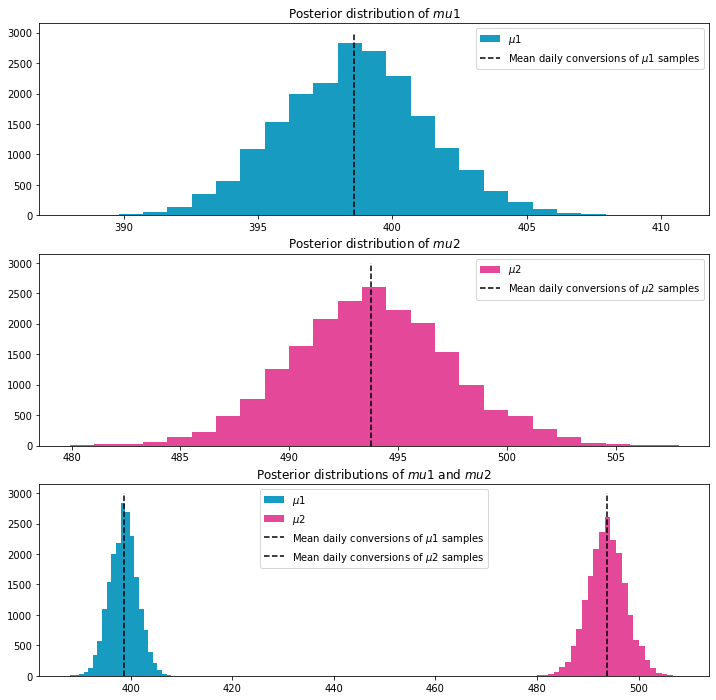

In [46]:
plt.figure(figsize = (12, 12))

ax = plt.subplot(311)
plt.hist(mu_1_samples, color = "#179bc1ff", histtype = 'stepfilled', bins = 25, label = "$\mu 1$")
plt.vlines(np.mean(mu_1_samples), 0, 3000, linestyle = "--", label = "Mean daily conversions of $\mu 1$ samples")
plt.legend(loc = "upper right")
plt.title("Posterior distribution of $mu 1$")

ax = plt.subplot(312)
plt.hist(mu_2_samples, color = "#e34998ff", histtype = 'stepfilled', bins = 25, label = "$\mu 2$")
plt.vlines(np.mean(mu_2_samples), 0, 3000, linestyle = "--", label = "Mean daily conversions of $\mu 2$ samples")
plt.legend(loc = "upper right")
plt.title("Posterior distribution of $mu 2$")

ax = plt.subplot(313)
plt.hist(mu_1_samples, color = "#179bc1ff", histtype = 'stepfilled', bins = 25, label = "$\mu 1$")
plt.vlines(np.mean(mu_1_samples), 0, 3000, linestyle = "--", label = "Mean daily conversions of $\mu 1$ samples")
plt.hist(mu_2_samples, color = "#e34998ff", histtype = 'stepfilled', bins = 25, label = "$\mu 2$")
plt.vlines(np.mean(mu_2_samples), 0, 3000, linestyle = "--", label = "Mean daily conversions of $\mu 2$ samples")
plt.legend(loc = "upper center")
plt.title("Posterior distributions of $mu 1$ and $mu 2$")

plt.savefig('distributions.png')